In [1]:
import flopy as fp
import numpy as np
import geopandas as gp
import pandas as pd
import seaborn as sns
import pickle
import os
import sys
import matplotlib.pyplot as plt
from flopy.utils.gridintersect import GridIntersect
from flopy.utils import Raster
import rasterio
import shapely
from scipy.optimize import minimize
from shapely.geometry import *
import time
import shutil

sys.path.insert(1, '../../modules')
# import modules
from Rouss import *
from Rouss3D import *
from ZoneBudget_ludo import *

sys.path.insert(1,"../../Model_val/upscalling/")
from upscalling_functions import*

flopy is installed in C:\Users\emmal\Anaconda3\lib\site-packages\flopy


In [2]:
model_dir = "working"
model_name = "I3D_2700"
exe_name= "../../exe/mf6"

In [13]:
def pred(elev_mar=0.3,coeff_p=1,i_rch="today",coeff_rch=1):
    
    """
    elev_mar : sea level rise (m)
    coeff_p : coefficient to apply on uptakes
    irch : which recharge ("today" or 2050 or 2080)
    coeff_rch : coefficient to apply on recharge
    coeff_irr : coefficient to apply on recharge from irrigation
    
    """
    
    model_dir = "working"
    model_name = "I3D_2700"
    exe_name= "../../exe/mf6"
    
    #rivers paths
    Agly_path = "../../data/Fleuves/Agly_ludo.shp" # path to Agly
    Tet_path = "../../data/Fleuves/Tet_ludo.shp"
    Rea_path = "../../data/Fleuves/Reart_ludo.shp"
    Tech_path = "../../data/Fleuves/Tech_ludo.shp"
    Bol_path = "../../data/Fleuves/Boules_ludo.shp"
    Cant_path = "../../data/Fleuves/Cant_ludo.shp"

    #stations paths
    Agly_stations = "../../data/Fleuves/stations_agly.csv" 
    Tet_stations = "../../data/Fleuves/stations_tet2.csv"
    Rea_stations = "../../data/Fleuves/stations_reart.csv"
    Tech_stations = "../../data/Fleuves/stations_tech.csv"
    Bol_stations = "../../data/Fleuves/stations_bol.csv"
    Cant_stations = "../../data/Fleuves/stations_cant.csv"
    
    # load dis infos
    top,botm,idomain,delr,delc = read_pickle(os.path.join(model_dir,"export_dis3D"))
    
    #spatial parameters

    MNT_path = "../../data/surfaces_geoter_decoup/TOPO (inf 0 en mer).asc"
    x0,y0,x1,y1 = rasterio.open(MNT_path).bounds

    nlay = idomain.shape[0]
    ncol = idomain.shape[2]
    nrow = idomain.shape[1]

    grid = fp.discretization.StructuredGrid(delc,delr,xoff=x0,yoff=y0) # create a grid identical to the dis package, will be used
                                                                       # to pre-process data
    ix = GridIntersect(grid)
    
    # Do a list of all active cells
    lst_domain = []
    for ilay in range(nlay):
        for irow in range(nrow):
            for icol in range(ncol):
                if idomain[ilay,irow,icol] == 1:
                    lst_domain.append((ilay,irow,icol))

    #uppermost active cell
    Up_cells_act = up_act_cell(idomain)
    
    
    # BC sea
    # import the shapefile that correspond to the BC
    BCsea_path = "../../data/shp/sea_bc_extended.shp"
    BC_sea = gp.read_file(BCsea_path)

    # extract cellids from the BC at the sea and make these cells active
    lst_chd = gp2cellids3D(grid,BC_sea,idomain,type="polygon",idomain_active=True,layer=0)

    # attribute a constant head at all the cells in the lst_chd
    chd_lst=[];chd_va=0.1
    for x in lst_chd:
#         chd_v = -0.025*top[x[1],x[2]] #equivalent freshwater head
#         if chd_v < 0:
#             chd_v = chd_va
#         chd_lst.append((x,chd_v))
         chd_lst.append((x,-5+(elev_mar+5)*1.025))
    
    # BC etangs
    BCetangs_path = "../../data/shp/Surface_hydro/SURFACE_HYDROGRAPHIQUE.shp"
    Bcet = gp.read_file(BCetangs_path)
    etangs = Bcet[(Bcet["TOPONYME"]=="étang de canet") | (Bcet["TOPONYME"]=="étang de leucate")]

    # extract cellids from the BC 
    etangs_chd = gp2cellids3D(grid,etangs.dissolve(by="NATURE"),idomain,idomain_active=True,layer=1)

    # attribute a constant head
    et_drn_lst=[];
    for x in etangs_chd:
        et_drn_lst.append((x,-5+(elev_mar+5)*1.025,1))
        
    Agy_chd = Complete_riv(Agly_path,Agly_stations,28,0.1,lst_chd=lst_chd,lst_domain=lst_domain,grid=grid)
    Tech_chd = Complete_riv(Tech_path,Tech_stations,180,0.1,lst_chd=lst_chd,lst_domain=lst_domain,grid=grid)
    Cant_chd = Complete_riv(Cant_path,Cant_stations,140,0.1,lst_chd=lst_chd,lst_domain=lst_domain,grid=grid)
    Rea_chd = Complete_riv(Rea_path,Rea_stations,100,0.1,lst_chd=lst_chd,lst_domain=lst_domain,grid=grid)
    Tet_chd = Complete_riv(Tet_path,Tet_stations,180,0.1,lst_chd=lst_chd,lst_domain=lst_domain,grid=grid)
    Bol_chd = Complete_riv(Bol_path,Bol_stations,180,0.1,lst_chd=lst_chd,lst_domain=lst_domain,grid=grid)

    lst_riv_chd=[Agy_chd,Tech_chd,Cant_chd,Rea_chd,Tet_chd,Bol_chd]
    cond = [0.01,0.01,0.001,0.01,0.0018,0.001]

    for iriv in range(len(lst_riv_chd)):
        chd2riv(lst_riv_chd[iriv],cond[iriv],2)
    
    
    # Prelevements
    geol_col = "NAPPE_CAPT" #name of lithology column
    v_col = "VOL_2013" # name of the volume column
    path = "../../data/prélèvements/donnees_sandra/SynthèseSLanini_data_Prelevements_1987-2018.shp" # path to shp
    BD = gp.read_file(path)

    #remove points with no geometry info
    for i in range(BD.shape[0]):
        if BD.geometry[i]==None:
            BD.drop(i,axis=0,inplace=True)
    BD  = BD[BD["USAGES"]!="IRRIGATION"]

    stress_data_well = importWells3D(BD,grid,lst_domain,fac=coeff_p*1/365/86400,V_col=v_col, geol_col=geol_col,
                                     geol_layer=["PLIOCENE","QUATERNAIRE","INDETERMINE"],layer_num=[[3,4],1,[1,3,4]])
    
    # Prelevements agricoles
    path_Q = "../../data/prélèvements/prlvm_agri_Q.asc"
    path_P = "../../data/prélèvements/prlvm_agri_P.asc"
    p_agri_Q = rspl_rast(path_Q,grid)
    p_agri_P = rspl_rast(path_P,grid)

    #pertes
    p_agri_Q*=1.25*coeff_p # 20% de pertes
    p_agri_Q*=1.25*coeff_p

    # make a list for rch package
    ## PQ
    p_agr=[]
    for icell in Up_cells_act:
        irow = icell[1]
        icol = icell[2]
        if p_agri_Q[irow,icol] != 0:
            if (1,irow,icol) in lst_domain:
                p_agr.append(((1,irow,icol),p_agri_Q[irow,icol]/1000/365/86400))
        if p_agri_P[irow,icol] != 0:
            if (3,irow,icol) in lst_domain:
                p_agr.append(((3,irow,icol),p_agri_P[irow,icol]/1000/365/86400))
            elif (4,irow,icol) in lst_domain:
                p_agr.append(((4,irow,icol),p_agri_P[irow,icol]/1000/365/86400))
   
                    
    # recharge
    rch_path="../../data/recharge/recharge_p.tif" # path to rch
    rch_path_2050 = "../../data/changements_clim/rast_rch_2050.tif"
    rch_path_2080 = "../../data/changements_clim/rast_rch_2080.tif"

    ## select recharge (0 : today, 1 : 2050, 2 : 2080)
    if i_rch == 2050:
        rch_path = rch_path_2050
    elif i_rch == 2080:
        rch_path = rch_path_2080
    elif i_rch == "today":
        pass
    else:
        raise Exception("Choose between 2050, 2080 or today")
    
    rch = rspl_rast(rch_path,grid) # resample to grid
    rch[rch<0]=np.mean(rch[rch>0]) # replace negative values by a mean

    rch[np.abs(idomain).sum(0)==0]=0 # remove some rch
    rch[idomain[0]==1]=0 # remove some rch
    for cell in etangs_chd:
        rch[cell[1],cell[2]]=0

    rch = liss_mob(rch,5)

    # make a list for rch package
    rch_lst=[]
    for icell in Up_cells_act:
        irow = icell[1]
        icol = icell[2]
        if rch[irow,icol] > 0:
            rch_lst.append(((icell),coeff_rch*rch[irow,icol]/1000/365/86400)) ## apply recharge coeff
    
    # coeff irr from inversion
    coeff_irr = (np.loadtxt(os.path.join("../../PEST++inv/3D_pp2700_VarQ0.5_a3000_VarP0.5_a5000/master_glm","irr.txt"))/
             np.loadtxt(os.path.join("../../PEST++inv/3D_pp2700_VarQ0.5_a3000_VarP0.5_a5000/workspace","irr.txt")))
    coeff_irr[np.isnan(coeff_irr)]=0
    
    #recharge irrigation
    irr_path = "../../data/recharge/rast_irr.asc"
    irr = rspl_rast(irr_path,grid)
    irr[irr<0]=0
    
    irr*=coeff_irr #### apply irrigation coeff

    irr_lst=[]
    for icell in Up_cells_act:
        irow = icell[1]
        icol = icell[2]
        if irr[irow,icol] !=0:
            irr_lst.append(((icell),irr[irow,icol]/1000/365/86400))
            
    # permeability
    pathkQ = "../../PEST++inv/3D_pp2700_VarQ0.5_a3000_VarP0.5_a5000/kQ.txt"
    pathkP = "../../PEST++inv/3D_pp2700_VarQ0.5_a3000_VarP0.5_a5000/kP.txt"
    kQ = 10**np.loadtxt(pathkQ)
    kQ[np.isnan(kQ)]=2e-3
    kP = 10**np.loadtxt(pathkP)
    kP[np.isnan(kP)]=1e-4

    k = np.ones([nlay,nrow,ncol])*1e-4
    k[0] = 1e-5
    k[1] = kQ # Q
    k[2] = 0.25e-8 # interQ/PC
    k[3] = kP #PC
    k[4] = 1e-5*0.19535 # PMS, multiply by 0.2 --> result from calibration
    
    ## Thuir
    layer = [1,3]
    poly = Polygon([(674e3,616.8e4),(674e3,617.4e4),(678e3,617.4e4),(678e3,616.8e4)])
    plio_chd = []

    for layer in layer:
        BDcells = cellidBD(idomain,layer=layer)

        for cellid in ix.intersect_polygon(poly).cellids:
            cell = (layer,cellid[0],cellid[1])
            if cell in BDcells:
                if layer == 1:
                    plio_chd.append((cell,140))
                if layer == 3:
                    plio_chd.append((cell,115))
                
    # Corbières
    layer = [3,4]
    Corb_lst = []
    Corb_spd = []
    flux = 0.2

    for layer in layer:
        BDcells = cellidBD(idomain,layer)
        poly = Polygon([(685e3,618.7e4),(685e3,619.5e4),(696e3,619.5e4),(696e3,618.7e4)])

        res = ix.intersect_polygon(poly)
        for cellid in res.cellids:
            cell = (layer,cellid[0],cellid[1])
            if cell in BDcells:
                Corb_lst.append(cell)
        n_cells = len(Corb_lst)

    for cell in Corb_lst:
        Corb_spd.append((cell,flux/n_cells))

    # basic modules
    sim = fp.mf6.MFSimulation(sim_name='I3D_2700_mf6', version='mf6', exe_name=exe_name, 
                             sim_ws=model_dir)
    gwf = fp.mf6.ModflowGwf(sim, modelname=model_name,
                               model_nam_file='{}.nam'.format(model_name))
    dis = fp.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                                  delr=delr, delc=delc,
                                  top=top, botm=botm,xorigin=x0,yorigin=y0,idomain=idomain)

    tdis = fp.mf6.ModflowTdis(sim, time_units='SECONDS',perioddata=[[1.0, 1, 1.]])
    ims  = fp.mf6.ModflowIms(sim, print_option='SUMMARY', complexity="simple")

    # initial conditions
    ic   = fp.mf6.ModflowGwfic(gwf,strt=botm+1)

    # output control
    oc   = fp.mf6.ModflowGwfoc(gwf,budget_filerecord='{}.cbc'.format(model_name),
                                head_filerecord='{}.hds'.format(model_name),
                                saverecord=[('HEAD', 'LAST'),
                                            ('BUDGET', 'LAST')],
                                printrecord=[('BUDGET', 'ALL')])

    # nodeflowproperty
    npf  = fp.mf6.ModflowGwfnpf(gwf, icelltype=0, k=k,save_flows=True,save_specific_discharge=True)

    #well
    wel = fp.mf6.ModflowGwfwel(gwf,pname="wel",maxbound=len(stress_data_well),
                               stress_period_data=stress_data_well,save_flows=True)

    # recharge
    rch = fp.mf6.ModflowGwfrch(gwf,pname = "rch",maxbound=len(rch_lst),stress_period_data=rch_lst,save_flows=True)

    # irrigation
    irri = fp.mf6.ModflowGwfrch(gwf,pname="irrig",filename="irri.rch",maxbound=len(irr_lst),stress_period_data=irr_lst,save_flows=True)

    p_ag = fp.mf6.ModflowGwfrch(gwf,pname="p_agri",filename="p_agri.rch",maxbound=len(p_agr),stress_period_data=p_agr,save_flows=True)


    #Corbières
    Corb = fp.mf6.ModflowGwfwel(gwf,pname="Corb",filename="Corb.wel",maxbound=len(Corb_spd),
                                stress_period_data=Corb_spd,save_flows=True)

    #constant heads
    chd = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='sea', filename="sea.chd", maxbound=len(chd_lst), 
                                                   stress_period_data={0: chd_lst}, save_flows=True)

    thuir = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='thuir', filename="thuir.chd", maxbound=len(plio_chd), 
                                                           stress_period_data={0: plio_chd}, save_flows=True)
    #etangs
    etangs = fp.mf6.modflow.mfgwfdrn.ModflowGwfdrn(gwf,pname="eta",filename="eta.drn",maxbound=len(et_drn_lst),
                                                  stress_period_data=et_drn_lst,save_flows=True)

    # Rivers
    Agly = fp.mf6.modflow.mfgwfriv.ModflowGwfriv(gwf,pname="agly",filename="agly.riv",maxbound=len(Agy_chd),
                                                    stress_period_data={0: Agy_chd}, save_flows=True)

    Riv2 = fp.mf6.modflow.mfgwfriv.ModflowGwfriv(gwf, pname='Tet', filename="Tet.riv", maxbound=len(Tet_chd), 
                                                   stress_period_data={0: Tet_chd}, save_flows=True)

    Riv3 = fp.mf6.modflow.mfgwfriv.ModflowGwfriv(gwf, pname='Rea', filename="Rea.riv", maxbound=len(Rea_chd), 
                                                   stress_period_data={0: Rea_chd}, save_flows=True)

    Riv6 = fp.mf6.modflow.mfgwfriv.ModflowGwfriv(gwf, pname='Cant', filename="Cant.riv", maxbound=len(Cant_chd), 
                                                   stress_period_data={0: Cant_chd}, save_flows=True)

    Riv4 = fp.mf6.modflow.mfgwfriv.ModflowGwfriv(gwf, pname='Tech', filename="Tech.riv", maxbound=len(Tech_chd), 
                                                   stress_period_data={0: Tech_chd}, save_flows=True)

    Riv5 = fp.mf6.modflow.mfgwfriv.ModflowGwfriv(gwf, pname='Bol', filename="Bol.riv", maxbound=len(Bol_chd), 
                                                   stress_period_data={0: Bol_chd}, save_flows=True)
    
    sim.write_simulation(silent=True)
    sim.run_simulation(silent=True)

In [14]:
pred(elev_mar=0,i_rch="today") # prediction for "today" --> 2013
head_today = get_heads(model_name,model_dir)
spdis_today = get_spdis(model_name,model_dir)

pred(elev_mar=.2,i_rch=2050) # predictions for 2050
head_2050 = get_heads(model_name,model_dir)
spdis_2050 = get_spdis(model_name,model_dir)

pred(elev_mar=.3,i_rch=2080) # predictions for 2080
head_2080 = get_heads(model_name,model_dir)
spdis_2080 = get_spdis(model_name,model_dir)

In [ ]:
# retrieve package name
bdfile=[]
for file in os.listdir(model_dir):
    if file.endswith(".chd"):
        bdfile.append(os.path.splitext(file)[0])

rivfiles=[]
for file in os.listdir(model_dir):
    if file.endswith(".riv"):
        rivfiles.append(os.path.splitext(file)[0])

In [ ]:
sim = fp.mf6.MFSimulation.load(sim_ws=model_dir)
m = sim.get_model(model_name.lower())
grid = m.modelgrid

Text(0.5, 1.0, '2080')

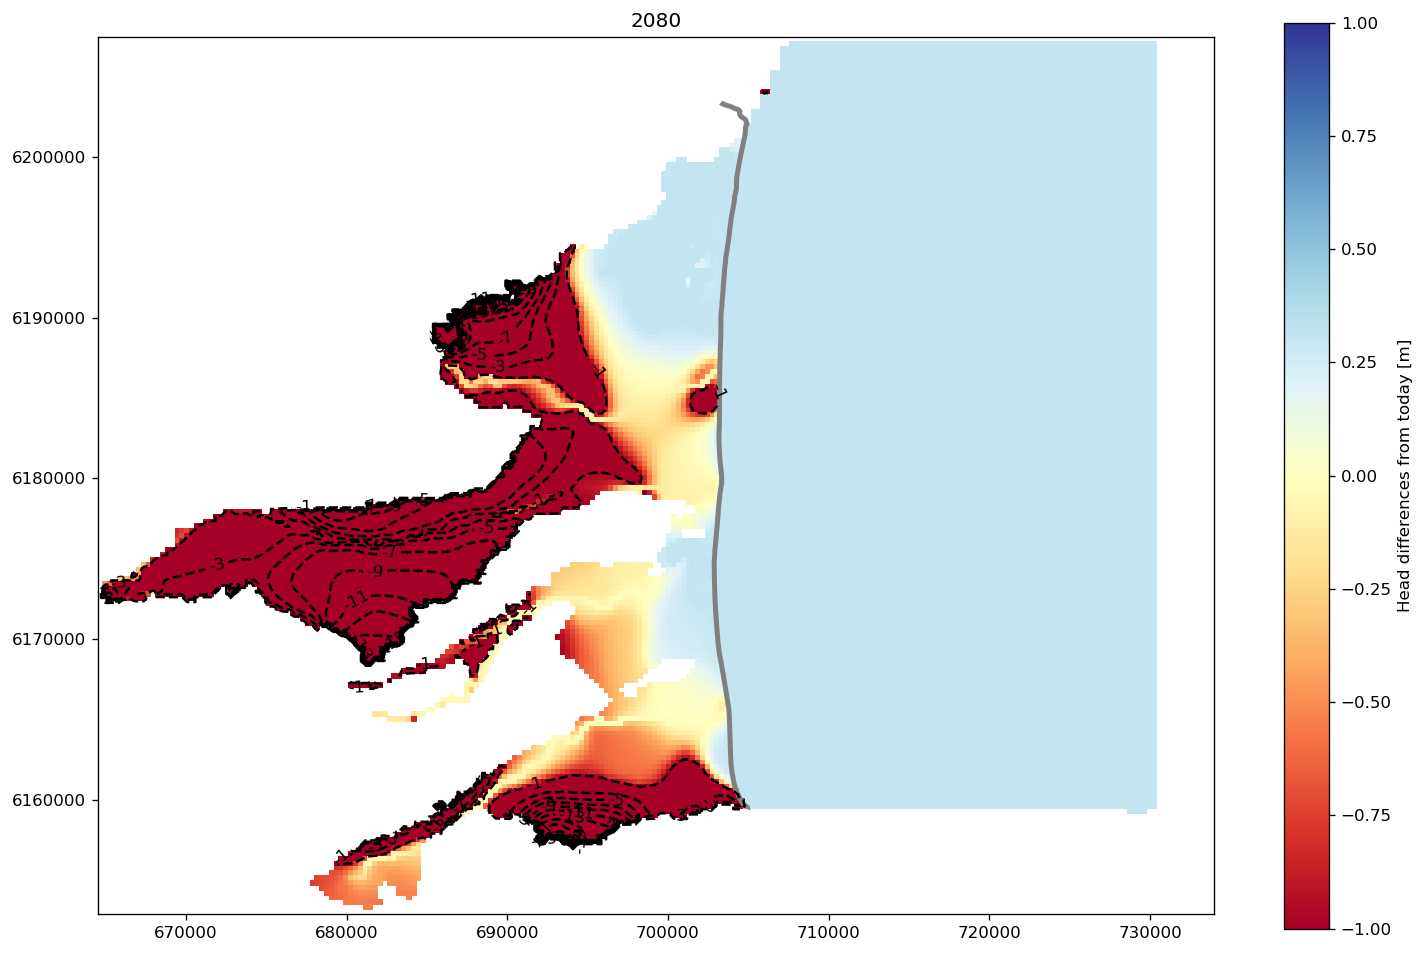

In [44]:
# initialize plot
fig = plt.figure(figsize=(15,10),dpi=120)
layer = 1
ax  = plt.subplot(1, 1,1, aspect='equal')
ml = fp.plot.PlotMapView(model=m,layer=layer)


hmesh = ml.plot_array(head_2080[layer]-head_today[layer],masked_values=[0,1e30],cmap="RdYlBu")
quiver = ml.contour_array(head_2080[layer]-head_today[layer],levels=np.arange(-25,0,2),colors='black')
plt.clabel(quiver,fmt="%1i")
hmesh.set_clim(-1,1)
c=plt.colorbar(hmesh)
c.set_label("Head differences from today [m]")

fp.plot.plot_shapefile("../../data/shp/ligne_cote.shp",edgecolor="grey",facecolor="none",linewidth=3)

plt.title("2080")

Text(0.5, 1.0, '2080')

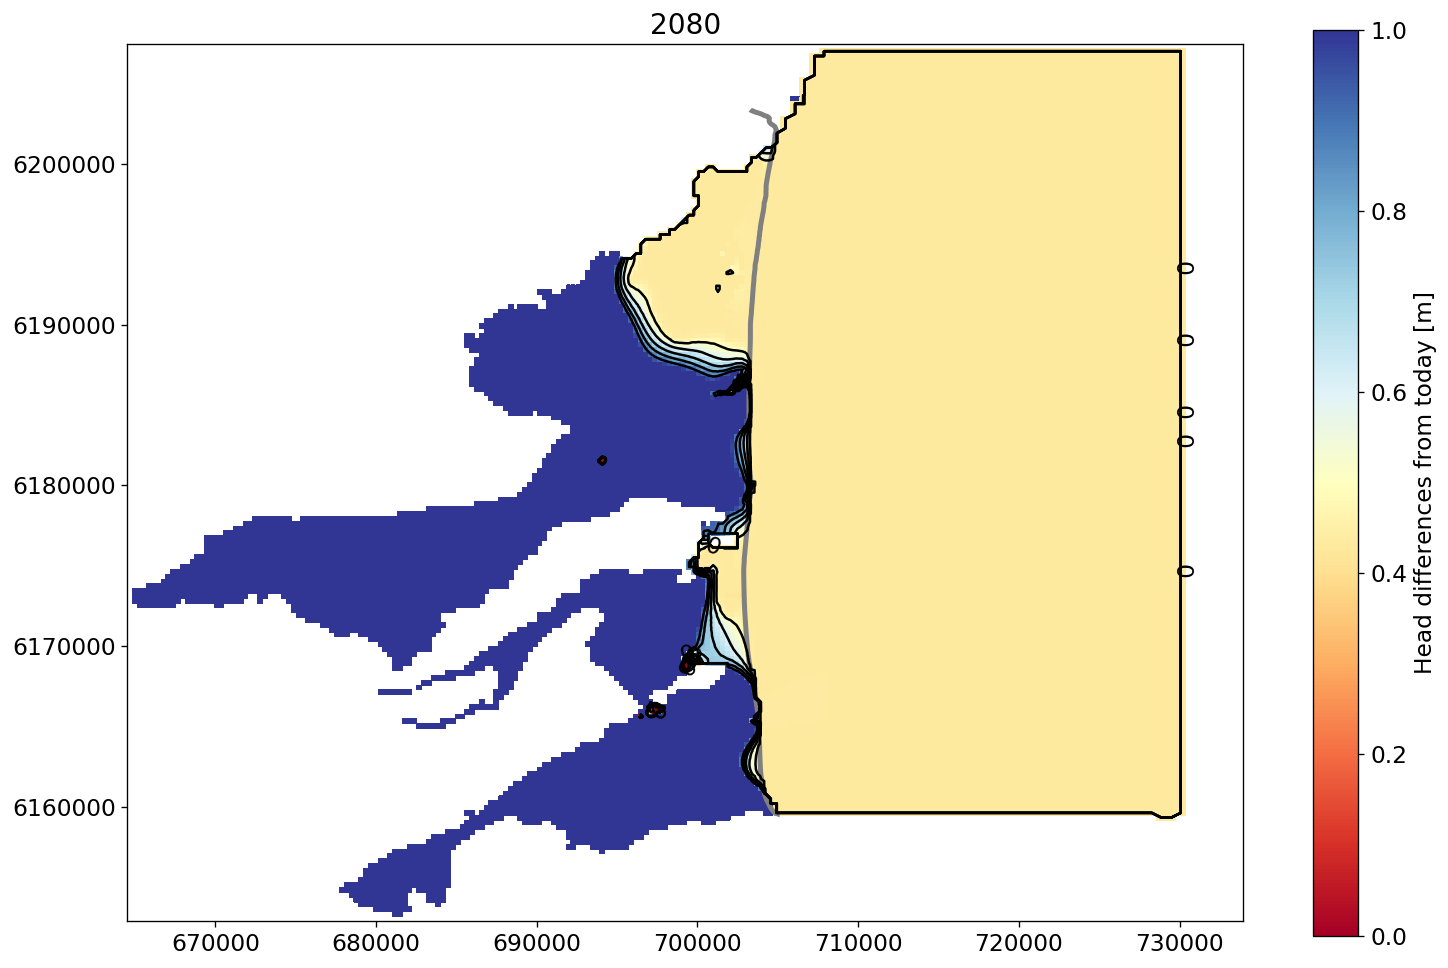

In [70]:
# initialize plot
fig = plt.figure(figsize=(15,10),dpi=120)
layer = 1
ax  = plt.subplot(1, 1,1, aspect='equal')
ml = fp.plot.PlotMapView(model=m,layer=layer)


hmesh = ml.plot_array(head_2080[layer],masked_values=[0,1e30],cmap="RdYlBu")
quiver = ml.contour_array(head_2080[layer],levels=np.arange(0,1,0.1),colors='black')
plt.clabel(quiver,fmt="%1i")
hmesh.set_clim(0,1)
c=plt.colorbar(hmesh)
c.set_label("Head differences from today [m]")

fp.plot.plot_shapefile("../../data/shp/ligne_cote.shp",edgecolor="grey",facecolor="none",linewidth=3)

plt.title("2080")

Text(0.5, 1.0, '2080')

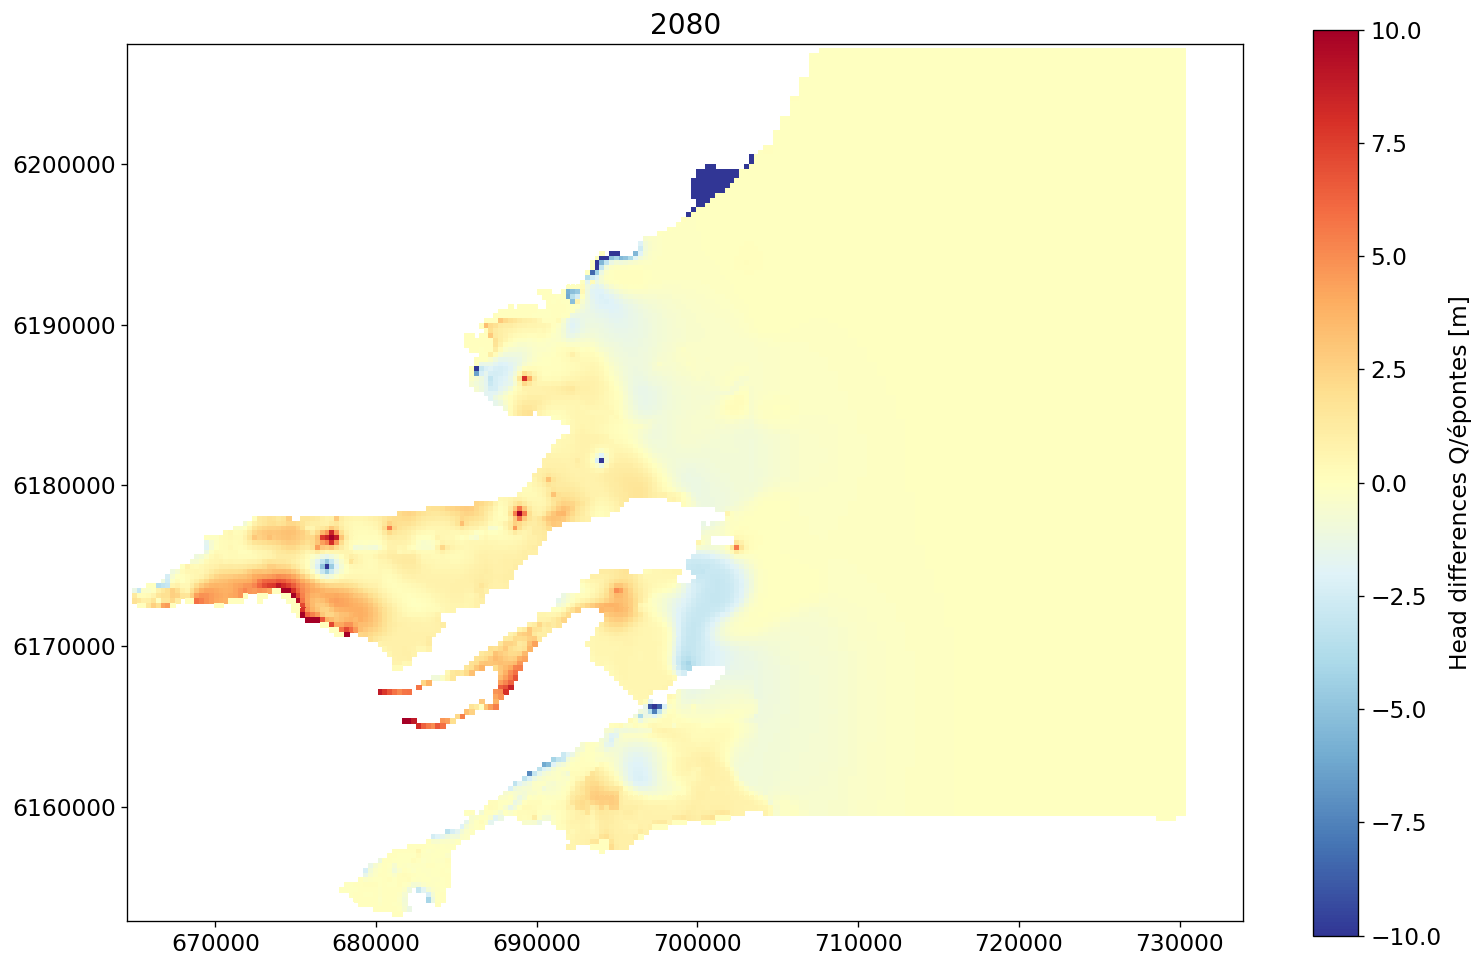

In [64]:
# initialize plot
fig = plt.figure(figsize=(15,10),dpi=120)
layer = 1
ax  = plt.subplot(1, 1,1, aspect='equal')
ml = fp.plot.PlotMapView(model=m,layer=layer)

hmesh = ml.plot_array(head_2080[layer]-head_2080[2],masked_values=[0,1e30],cmap="RdYlBu_r")
hmesh.set_clim(-10,10)
c=plt.colorbar(hmesh)
c.set_label("Head differences Q/épontes [m]")

plt.title("2080")

(-400, 220)

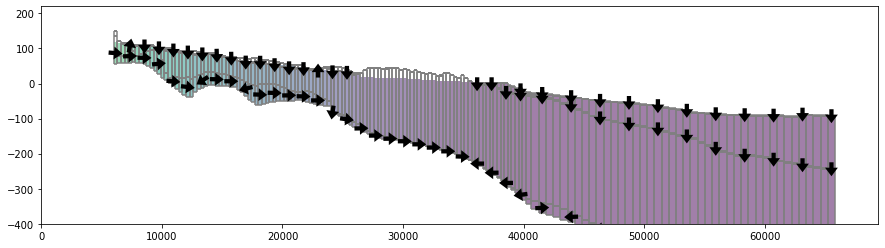

In [42]:
fig,ax = plt.subplots(1,1,figsize=(15,4))

x=fp.plot.PlotCrossSection(m,line={"row" :100})
arr = x.plot_array(head,masked_values=[1e30],head=head,alpha=0.5)
quiver = x.plot_specific_discharge(spdis_2080, head=head, 
                       hstep=4,kstep=2,normalize=True, facecolor='black', 
                       scale=60, headwidth=3, headlength=2, headaxislength=2,
                       zorder=5)
arr.set_clim(0,170)
x.plot_ibound()
x.plot_grid()
ax.set_ylim(-400,220)

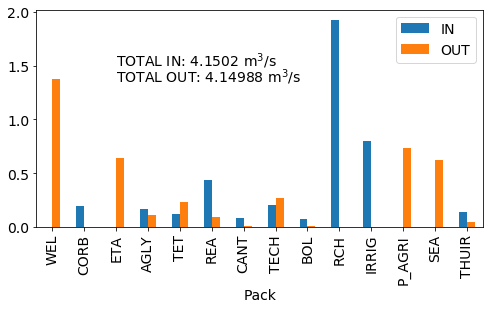

In [50]:
#total budget

fig,ax = plt.subplots(figsize=(8,4))
Budget = get_Total_Budget(model_name,model_dir)
Budget.set_index("Pack",inplace=True)
Budget.plot(kind="bar",ax=ax)
ax.text(2,1.5,"TOTAL IN: {} m$^3$/s".format(np.round(Budget.sum()["IN"],decimals=5)));
ax.text(2,1.35,"TOTAL OUT: {} m$^3$/s".format(np.round(Budget.sum()["OUT"],decimals=5)));

In [61]:
top,botm,idomain,delr,delc = read_pickle(os.path.join(model_dir,"export_dis3D"))
nlay,nrow,ncol=idomain.shape

MNT_path = "../../data/surfaces_geoter_decoup/TOPO (inf 0 en mer).asc"
x0,y0,x1,y1 = rasterio.open(MNT_path).bounds

# control piezos
piez_path="../../data/piezos/pz_hydriad.xlsx"

#import the data using ImportControlPz3D (path,modelgrid, sheetname of the data,piezometric level column, x and y coor (in L93 !))
geol_layer = ["Quaternaire","Pliocène"]
geol_col = "AquifèreCapté"
Control_Pz = ImportControlPz3D(piez_path,sheet_name="2012",geol_layer=geol_layer,layer_num=[1,3],geol_col=geol_col,
                               grid=grid,nlay=nlay,np_col = "NP_Avril2013")

# Return a 3d array (nlay,nrow,ncol) that can be directly substract with head (each pz is a measure of one cell)

C:\Users\emmal\Anaconda3\lib\site-packages\xlrd\xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\Users\emmal\Anaconda3\lib\site-packages\xlrd\xlsx.py:312: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\Users\emmal\Anaconda3\lib\site-packages\xlrd\xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():


Misfit : 3.5906026104114197 m 
MSE    : 33.1531212320459
φ      : 4044.680790309599


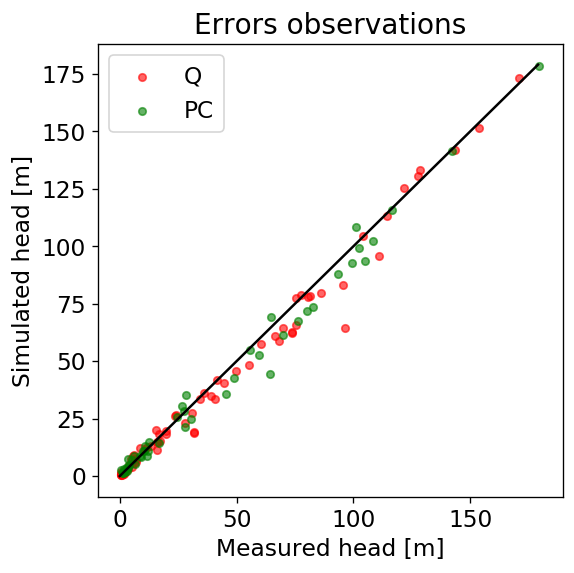

In [47]:
plt.rcParams.update({'font.size': 14})
head = get_heads(model_name,model_dir)
color = ["y","r","b","g","k"]
label = ["sea","Q","inter","PC","PMS"]
fig = plt.figure(figsize=(5,5),dpi=120)

for ilay in [1,3]:
    Control_pz = Control_Pz[ilay].reshape(nrow*ncol)
    head_c = head[ilay].reshape(nrow*ncol)
    
    head_c[head_c>1000]=None
    if (Control_pz!=0).any():
        plt.scatter(Control_pz[Control_pz!=0],head_c[Control_pz!=0],s=20,c=color[ilay],label=label[ilay],alpha=0.6)
plt.legend()
plt.plot(np.arange(180),np.arange(180),"k")
plt.xlabel("Measured head [m]")
plt.ylabel("Simulated head [m]")
plt.title("Errors observations")

# stats
Control_pz = Control_Pz.reshape(nlay*nrow*ncol)
head_2 = head.reshape(nlay*nrow*ncol)
Misfit = np.abs((Control_pz[Control_pz!=0] - head_2[Control_pz!=0]))
MSE = np.nanmean((Control_pz[Control_pz!=0] - head_2[Control_pz!=0])**2)
phi = np.nansum((Control_pz[Control_pz!=0] - head_2[Control_pz!=0])**2)
print("Misfit : {} m ".format(np.nanmean(Misfit)))
print("MSE    : {}".format(MSE))
print("\u03C6      : {}".format(phi))

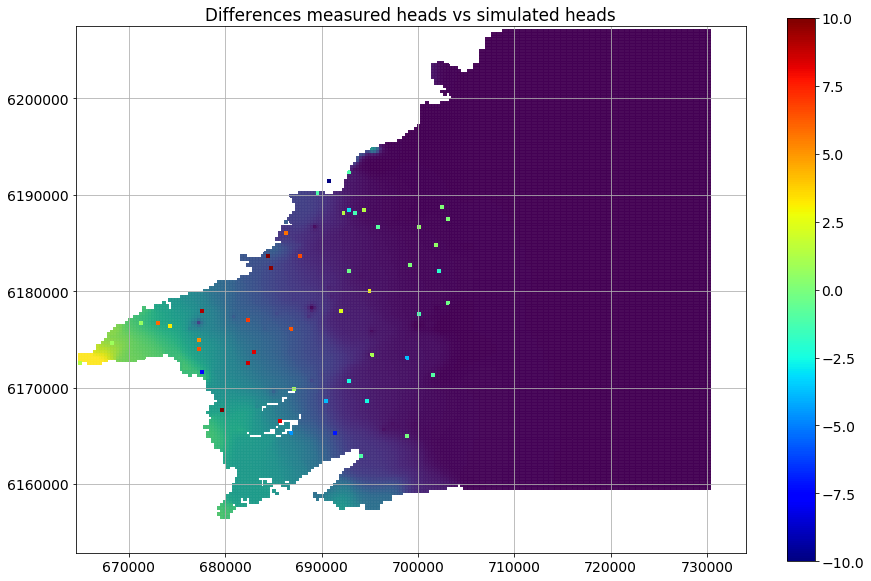

In [52]:
# retrieve heads
head = get_heads(model_name,model_dir)

# initialize plot
fig = plt.figure(figsize=(15,10))
layer = 3
ax  = plt.subplot(1, 1,1, aspect='equal')
ml = fp.plot.PlotMapView(model=m,layer=layer)

back = ml.plot_array(head[layer],masked_values=[1e30],alpha=0.8)
back.set_clim(0,170)

head = head.reshape(nlay*nrow*ncol)
head[Control_pz==0]=None
comp = (Control_pz - head).reshape(nlay,nrow,ncol)
err = ml.plot_array(comp[layer],cmap="jet",vmin=-10,vmax=10)

plt.title("Differences measured heads vs simulated heads")

plt.colorbar(err)
plt.grid()

In [35]:
def Misfit(kh):
    
    fp.mf6.mfpackage.MFPackage(gwf,package_type="npf").remove()# remove pre-existing npf package
    
    
    #permea
    ########------------------------------- 
    
    # layers
    K = np.ones([nlay,nrow,ncol])
    K[0] = 1e-6
    K[1] = kh[0]
    K[2] = 0.25e-8
    K[3] = kh[1]
    K[4] = kh[2]
    
    # zone sud
#     z1 = [(689e3,616e4),(695e3,616.3e4),(703e3,616.3e4),(703e3,615.2e4),(689e3,615.2e4)]
#     layer = [1,3,4]
#     kn = kh[2]
#     k_zones (K,z1,layer,kn,ix)
    
#     # permeabilité de la zone Villeneuve
#     x0_d,y0_d,x1_d,y1_d = 690e3,616.5e4,700e3,617.3e4
#     zv = [(x0_d,y0_d),(x0_d,y1_d),(x1_d,y1_d),(x1_d,y0_d)]
#     layer = [1,3,4]
#     kn = kh[3]
#     k_zones(K,zv,layer,kn,ix)
    
#     # permea alluv ancien Tet
#     shp = "../../data/shp/entités/Tet_Q_anc.shp"
#     poly = gp.read_file(shp).geometry[0]
#     layer = [1]
#     kn = kh[4]
#     k_zones(K,poly,layer,kn,ix)
    
    ########-------------------------------------
    
    npf  = fp.mf6.ModflowGwfnpf(gwf, icelltype=0, k=K) # create the new npf package
    npf.write()
    
    if sim.run_simulation(silent = True): # And RUN !
        head = get_heads(model_name,model_dir)
        head[head>1000]=None
        head = head.reshape(nlay*nrow*ncol)
        
    return np.nanmean(np.abs((Control_pz[Control_pz!=0] - head[Control_pz!=0])))

In [36]:
# minimize(Misfit,[2e-3,9.8e-5,1e-5],method="Nelder-Mead")

### budget by zones

In [53]:
from Zone_Budget_mf6 import Zb

In [54]:
%%time
#create the zones
a = np.array([1,2,4,4,6]) # Quat, eponte + PC, PMS
a = a[np.newaxis,np.newaxis,:]
zones = np.ones([nlay,nrow,ncol])*a.T
#zones[idomain==0]=0
#zones[0][idomain[0]==1]=0 # Quat marin
zones[1][idomain[0]==1]=3 # Quat marin
zones[3][idomain[0]==1]=5 # Pc marin

dic_zones = {1:"interfQ",
            2 : "Q",
            3 : "Q marin",
            4 : "PC",
            5 : "PC marin",
            6 : "PMS"} # dic to attribute zone names !

#remove some pack cells from zone 1 with ra_pack
#ra_pack(chd,zones,iper=0,value=5)
#ra_pack(Riv2,zones,iper=0,value=6)
#ra_pack(Riv3,zones,iper=0,value=7)

# initiate object
zb = Zb(zones,model_name,model_dir,cbc=get_cbc(model_name,model_dir),dic_zones=dic_zones,m_n=2)
DF_Budg = zb.get_Budget() # get DF budget

Wall time: 3.84 s


In [55]:
(np.round(DF_Budg,decimals=4)).replace(0,"/")

interfQ               Q         Q marin              PC          \
            FROM      TO    FROM      TO    FROM      TO    FROM      TO   
WEL            /       /       /  0.4512       /       /       /   0.459   
CORB           /       /       /       /       /       /   0.099       /   
ETA            /       /       /  0.6428       /       /       /       /   
AGLY           /       /  0.1669  0.1164       /       /       /       /   
TET            /       /  0.1159  0.2298       /       /  0.0027  0.0035   
REA            /       /  0.2461  0.0949       /       /    0.18       /   
CANT           /       /  0.0403  0.0102       /       /  0.0417       /   
TECH           /       /  0.2042  0.2659       /       /       /       /   
BOL            /       /  0.0717  0.0137       /       /       /       /   
RCH            /       /  1.2931       /       /       /  0.6154       /   
IRRIG          /       /   0.793       /       /       /  0.0064       /   
P_AGRI         /       /       /  0.5173       /       /       /   0.205   
SEA       0.0004  0.6214       /       /       /       /       /       /   
THUIR          /       /  0.1212  0.0017       /       /  0.0137  0.0377   
interfQ        /       /       /       /  0.0004  0.6071       /       /   
Q              /       /       /       /  0.3265  0.0012  1.0018  0.6185   
Q marin   0.6071  0.0004  0.0012  0.3265       /       /  0.0004  0.2818   
PC             /       /  0.6185  1.0018  0.2818  0.0004       /       /   
PC marin  0.0143       /       /       /       /       /  0.2946  0.3078   
PMS            /       /       /       /       /       /  0.2577     0.6   

         PC marin             PMS          
             FROM      TO    FROM      TO  
WEL             /       /       /  0.4613  
CORB            /       /   0.101       /  
ETA             /       /       /       /  
AGLY            /       /       /       /  
TET             /       /       /       /  
REA             /       /  0.0119       /  
CANT            /       /   0.002       /  
TECH            /       /       /  0.0009  
BOL             /       /       /       /  
RCH             /       /   0.016       /  
IRRIG           /       /  0.0027       /  
P_AGRI          /       /       /  0.0121  
SEA             /       /       /       /  
THUIR           /       /       /       /  
interfQ         /  0.0143       /       /  
Q               /       /       /       /  
Q marin         /       /       /       /  
PC         0.3078  0.2946     0.6  0.2577  
PC marin        /       /  0.0011  0.0022  
PMS        0.0022  0.0011       /       /

KeyError: 5

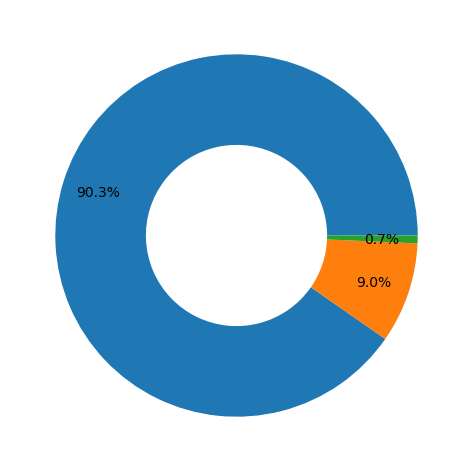

In [68]:
#plots donuts
nzones = get_nzones(zones)
if os.path.exists('pictures'):
    shutil.rmtree('pictures')
os.makedirs("pictures")

z_list = DF_Budg.index[-nzones:]
I_O_list = ["TO","FROM"]

dic_zones ={1:"Quaternaire",2:"InterQ_PC",3:"PC",4:"PMS"} # titles for zones

for z in z_list:
    for IN_OUT in I_O_list:
        fig,ax = plt.subplots(figsize=(9,6),dpi=100)
        labels = DF_Budg[DF_Budg[z][IN_OUT]!=0].index
        data = DF_Budg[z][IN_OUT][DF_Budg[z][IN_OUT]!=0].values
        data_pourc = DF_Budg[z][IN_OUT][DF_Budg[z][IN_OUT]!=0]/DF_Budg[z][IN_OUT][DF_Budg[z][IN_OUT]!=0].sum()
        
        wedges, texts,pct = ax.pie(data_pourc.values,pctdistance=0.8,
                                   wedgeprops=dict(width=0.5),autopct='%1.1f%%', startangle=0)

        bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0)
        kw = dict(arrowprops=dict(arrowstyle="<-"),
                  bbox=bbox_props, zorder=0, va="center")
        xt = -5
        yt = -5
        ### arrows
        """
        for i, p in enumerate(wedges):
            xta = xt
            yta = yt
            ang = (p.theta2 - p.theta1)/2. + p.theta1
            
            ang +=0.1
            y = np.sin(np.deg2rad(ang))
            x = np.cos(np.deg2rad(ang))
            xt = 1.3*np.sign(x)
            yt = 1.2*y
            if xt == xta:
                while((yta-yt)**2)< 0.0001:
                    if yt >= yta:
                        yt += 0.0001
                    else:
                        yt -= 0.0001
            horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
            connectionstyle = "angle,angleA=0,angleB={}".format(ang)
            kw["arrowprops"].update({"connectionstyle": connectionstyle})
            annote = np.round(data[i],2)
            ax.annotate(annote, xy=(x, y), xytext=(xt,yt),
                        horizontalalignment=horizontalalignment, **kw)
        ###
        """
        ax.set_title("{} : {}".format(dic_zones[int(z[-1])],IN_OUT))
        ax.set_position([0.1,0.1,0.5,0.7])
        ax.legend(wedges,labels,bbox_to_anchor=(1.5, 1))
        ax.text(-0.40,0,"TOTAL : {} m$^3/$s".format(np.round(data.sum(),3)))
        fig.savefig('pictures/{}_{}.png'.format(z,IN_OUT))
        plt.close()

In [56]:
def north(zoom=0.01,x0=664525+5e3,y0=6152875+5e3):
    
    """
    Plot a north image for maps
    """
    
    from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    
    arr_lena = mpimg.imread("../../images/north.png") # get image
    imagebox = OffsetImage(arr_lena,zoom=zoom) # create an image box
    ab = AnnotationBbox(imagebox, (x0,y0),frameon=False) # create the annotation box
    ax.add_artist(ab) # add the image

### Plots

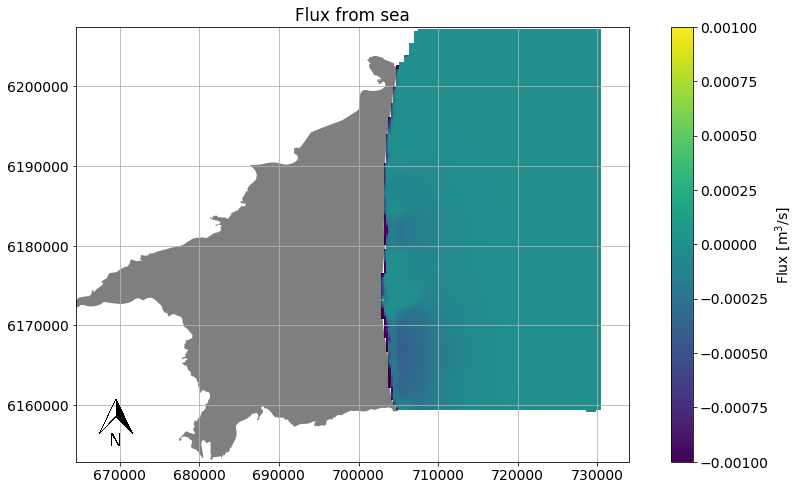

In [63]:
fig=plt.figure(figsize=(15,8))
ax  = plt.subplot(1, 1,1, aspect='equal')
ml = fp.plot.PlotMapView(model=m,layer=0)

g=zb.return_arr("SEA")
g=ml.plot_array(g)
g.set_clim(-0.001,0.001)


fp.plot.plot_shapefile("../../data/shp/limiteModeleRoussillon_poly.shp",facecolor="k",edgecolor="none",linewidth=1,alpha=.5)

plt.grid()
plt.title("Flux from sea")
c=fig.colorbar(g)
c.set_label("Flux [m$^3$/s]")

north(0.02)

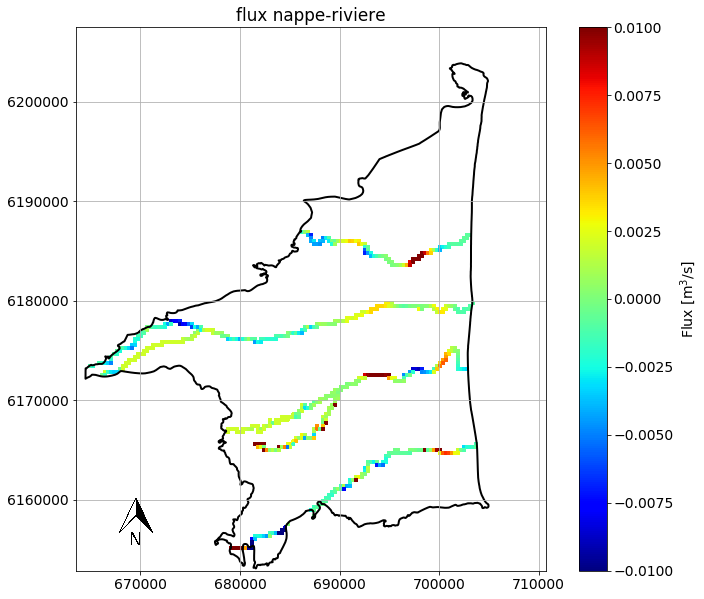

In [62]:
fig=plt.figure(figsize=(12,10))
ax  = plt.subplot(1, 1,1, aspect='equal')
ml = fp.plot.PlotMapView(model=m,layer=0)


riv = ["AGLY","BOL","TET","CANT","REA","TECH"]
for iriv in riv:
    g=zb.return_arr(iriv)
    g = ml.plot_array(g)
    g.set_cmap("jet")
    g.set_clim(-0.01,0.01)
    ax.set_xlim(x0-1e3,x1-2.4e4)
c = fig.colorbar(g)
c.set_label("Flux [m$^3$/s]")
fp.plot.plot_shapefile("../../data/shp/limiteModeleRoussillon_poly.shp",facecolor="none",edgecolor="k",linewidth=2)

plt.grid()
plt.title("flux nappe-riviere")
north(0.02)

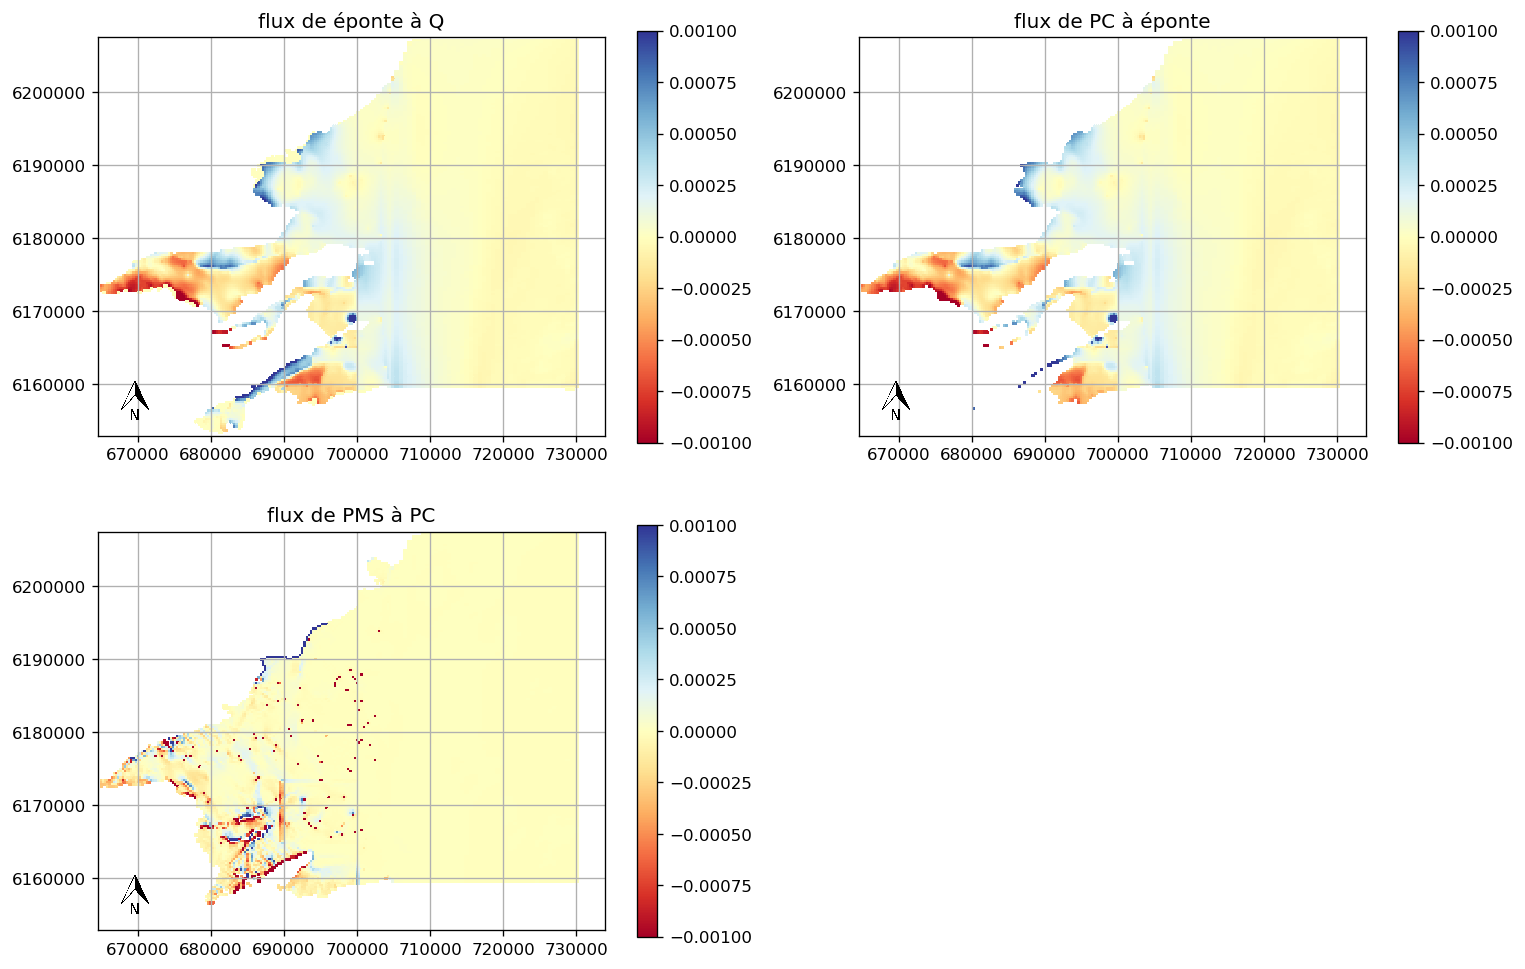

In [67]:
fig = plt.figure(figsize=(15,10),dpi=120)
fig.subplots_adjust(hspace=0.2, wspace=0.2)

for ilay in range(1,nlay-1):
    ax = fig.add_subplot(2,2,ilay)
    ax.set_aspect("equal")
    g = zb.Z2Z_3D(ilay,ilay+1)[ilay]
    g=ml.plot_array(g,ax=ax,cmap = "RdYlBu" )
    g.set_clim(-1e-3,1e-3)
    fig.colorbar(g)
    plt.grid()
    plt.title("flux de {} à {}".format(dic_zones[ilay+1],dic_zones[ilay]))
    north(0.01)